In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
#sys.path.insert(1, '/home/georgeos/Documents/GitHub/SyMBac//') # Not needed if you installed SyMBac using pip
sys.path.insert(1, '../SyMBac/')

from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
from SyMBac.colony_simulation import ColonySimulation
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
from glob import glob
import shutil
from skimage.transform import rotate


/home/gh464/Documents/GitHub/SyMBac/SyMBac/colony_simulation.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import global_params

['data/test/1', 'data/test/2', 'data/test/3', 'data/test/4', 'data/test/5', 'data/test/6', 'data/test/7', 'data/test/8', 'data/test/9', 'data/test/10']


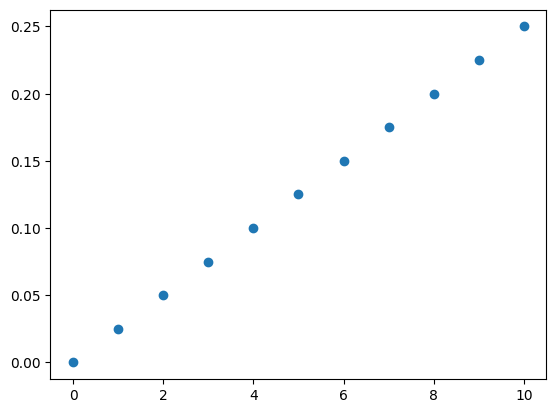

In [4]:
colonysim = ColonySimulation(
    cellmodeller_model= global_params.cellmodeller_model,
    max_cells = global_params.max_cells,
    pix_mic_conv = global_params.pix_mic_conv,
    resize_amount = global_params.resize_amount,
    save_dir = "test/"
)
print(colonysim.get_simulation_dirs())
_ = (colonysim.get_simulation_pickles())
colonysim.get_max_scene_size()


mean_density_modifier = 10

n_CVs = 11
stds = np.linspace(0,2.5, n_CVs)


CVs = stds/mean_density_modifier
plt.scatter(range(len(CVs)), CVs)

In [5]:
#for std in tqdm(stds):
#    colonysim.draw_simulation_OPL(n_jobs = -1, FL=True, density = 0.1, random_distribution = "normal", distribution_args = (mean_density_modifier, std), as_3D = True, crop=True, crop_pad=50)

In [6]:
from SyMBac.colony_renderer import ColonyRenderer

In [7]:
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter

from skimage.exposure import rescale_intensity


In [8]:
try:
    os.mkdir("simulated_colonies_normal")
except:
    pass

In [9]:
## Large simulation space, narrowed down for final analysis
#NAs = np.linspace(0.5, 1.49, 5)
#ns = np.linspace(1, 1.518, 5)
#wavelengths = [0.45, 0.5, 0.575,  0.65]
#names = ["blue", "green", "orange", "far red"]

#NAs = list(reversed([1.49, 0.95, 0.75]))
#ns = list(reversed([1.518, 1.0, 1.0]))
#working_distances = list(reversed([170, 570, 1000]))
#wavelengths = list(reversed([0.4, 0.55,  0.7]))
#names = list(reversed(["blue", "green", "orange", "far red"]))
#cell_depth = 1 #micron


NAs = list(reversed([1.49, 0.95]))
ns = list(reversed([1.518, 1.0]))
working_distances = list(reversed([170, 570]))
wavelengths = list(reversed([0.4, 0.55,  0.7]))
names = list(reversed(["blue", "green", "red"]))
cell_depth = 1 #micron

In [10]:
sim_params = [
    (v, u, t) 
    for v, u in zip(NAs, ns)
    for t in wavelengths]
len(sim_params)

6

In [11]:
pbar = tqdm(total = len(sim_params))
for wavelength, name in zip(wavelengths, names):
    for NA, n, working_distance in zip(NAs, ns, working_distances):
        if glob(f"simulated_colonies_normal/training_data_100x_{wavelength}_{name}_{NA}_{n}"):
            pass
        else:
            print(NA, n, working_distance, wavelength)
            my_kernel = PSF_generator(
                radius = 250, 
                wavelength = wavelength, 
                NA=NA, 
                n = n, 
                resize_amount=global_params.resize_amount, 
                pix_mic_conv=global_params.pix_mic_conv, 
                apo_sigma = 10, 
                mode="3d fluo", 
                condenser="Ph3", 
                z_height = int(round(1/global_params.pix_mic_conv)),
                pz = 0.5,
                working_distance = working_distance
            )
            my_kernel.calculate_PSF()
            my_kernel.kernel /= np.sum(my_kernel.kernel) # normalise so kernel sums to 1
            my_kernel.plot_PSF()
            # Commented out kernel offset and offset apodisation as difficult to justify other than "images seem more realistic"
            #my_kernel.kernel += 0.006
            #my_kernel.kernel *= PSF_generator.gaussian_2D(300, 70)
            my_renderer = ColonyRenderer(colonysim, my_kernel, force_2D = True)
            
            print(len(my_renderer.OPL_dirs))
            my_renderer.generate_random_samples(len(my_renderer.OPL_dirs), 0, f"simulated_colonies_normal/training_data_100x_{wavelength}_{name}_{NA}_{n}", GPUs=[1], n_jobs = 2, gpu_fraction=0.5, batch_size = 50)
            pbar.update()
pbar.close()

In [11]:
try:
    os.mkdir("simulated_colonies_empirical_PSF_corrected")
except:
    pass

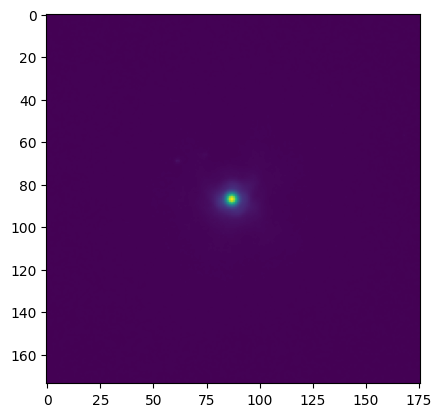

In [14]:
import tifffile
from skimage.transform import rescale
real_PSF = tifffile.imread("single_100x_PSF_postmag.tif").astype(np.float32)
c = int((real_PSF.shape[-1] - 200)/2)
x_offset = 2
y_offset = 3.5
real_PSF_slice = 44
real_PSF = real_PSF[real_PSF_slice-10:real_PSF_slice+10,2].sum(axis=0) # 0.05micron z step
real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
real_PSF = real_PSF[c-int(np.floor(y_offset)):-c-int(np.ceil(y_offset)),c-int(np.floor(x_offset)):-c+1-int(np.ceil(x_offset))]
real_PSF = rescale(real_PSF, (0.0655/1.5) / global_params.pix_mic_conv  , anti_aliasing=True)
real_PSF = real_PSF/real_PSF.sum()
plt.imshow(real_PSF)

In [13]:
my_kernel = PSF_generator(
    radius = 250, 
    wavelength = 0.55, 
    NA=1.49, 
    n = 1.518, 
    resize_amount=global_params.resize_amount, 
    pix_mic_conv=global_params.pix_mic_conv, 
    apo_sigma = 10, 
    mode="3d fluo", 
    condenser="Ph3", 
    z_height = 22,
    pz = 0.5,
    working_distance = 170
)
my_kernel.kernel = np.array([real_PSF]*22)
my_renderer = ColonyRenderer(colonysim, my_kernel, force_2D = True)

print(len(my_renderer.OPL_dirs))
my_renderer.generate_random_samples(len(my_renderer.OPL_dirs), 0, f"simulated_colonies_empirical_PSF_corrected/training_data_100x_0.55_green_1.49_1.518", GPUs=[1], n_jobs = 2, gpu_fraction=0.5, batch_size = 50)

3476


2023-05-12 08:26:09,565	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(autoscaler +26s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +26s) Warning: The following resource request cannot be scheduled right now: {'GPU': 0.5, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [15]:
my_kernel.kernel.shape

(22, 174, 176)